### 필요한 라이브러리 다운로드 및 임포트

In [1]:
#%pip install -U git+https://github.com/albumentations-team/albumentations
#%pip install opencv-python
#%pip install seaborn
#%pip install pandas
#%pip install matplotlib
#%pip install tensorflow
#%pip install opendatasets

In [2]:
import tensorflow
print("Current tensorflow version == {}".format(tensorflow.__version__))

Current tensorflow version == 2.7.0


In [3]:
import os
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import cv2
from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img
import albumentations as A
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

In [5]:
import time  
import datetime #https://bio-info.tistory.com/143
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, ResNet50, Xception, InceptionV3
from tensorflow.keras.applications import EfficientNetB0 
from tensorflow.keras import Input
from tensorflow.keras import regularizers

In [6]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

### 데이터세트 로딩 및 살펴보기 Load Dataset and Exploration 

In [7]:
import opendatasets as od
#od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

In [8]:
# 이미지 디렉토리 검색
img_dir = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray'
print(os.listdir(img_dir))

['test', 'train', 'val', '__MACOSX']


In [9]:
## 폴더를 직접 지정하는 방법 (1) 
train_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train'
val_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val'
test_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test'

In [10]:
## 각 이미지 경로들을 glob라이브러리와 와일드카드를 이용해 리스트화 (2)
train_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
val_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")
test_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
print(train_list[:1])
print(val_list[:1])
print(test_list[:1])

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\NORMAL\\IM-0001-0001.jpeg']


In [11]:
print("The number of the training dataset is {}".format(len(train_list)))
print("The number of the validation dataset is {}".format(len(val_list)))
print("The number of the test dataset is {}".format(len(test_list)))

The number of the training dataset is 5216
The number of the validation dataset is 16
The number of the test dataset is 624


#### 학습 및 벨리데이션 데이터 다시 나누기 Train Val data Split
- X-ray 이미지를 환자에게서 스캔시, 환자가 항상 특정한 포지션을 취한 뒤 촬영하고, 결과물 이미지도 같으므로 데이터 이미지 증식을 따로 할 필요가 없다고 생각됩니다. 따라서, 이미지를 플립하거나, 로테이션 하는 등의 전처리는 진행하지 않는것이 처음의 플랜이었습니다.
하지만 폐렴 이미지가 건강한 폐 이미지보다 많습니다. 이는 데이터의 class imabalnce를 의미하므로, 모델이 편향되게 학습될 수 있음을 의미합니다. 따라서 각 클래스의 양을 비슷하게 만들기 위해서 할 수 있는 방법 중 data augmentationd을 통해 변형된 이미지를 증가시켜 추후 학습시 모델이 편향되지 않도록 전처리를 진행하였습니다. (train/NORAML 폴더에 augmented 된 이미지 저장)
- 밸리데이션 세트의 이미지가 16개로 너무 적은 느낌이 있습니다. 따라서, 학습 데이터와 벨리데이션 세트를 합친후, 다시 train_test_split 으로 나누겠습니다. 

In [ ]:
# 데이터 증강에 사용할 이미지 변형 함수 정의
def augment(image):
    # 이미지 크기를 조정
    image = tensorflow.image.resize(image, size=[224, 224])
    # 이미지를 랜덤하게 좌우 반전, 50% 확률로 플립
    image = tensorflow.image.random_flip_left_right(image) 
    # 이미지의 픽셀 값을 0~1 범위로 조정
    image = tensorflow.clip_by_value(image, 0.0, 255.0) / 255.0
    return image

# 정상폐 데이터를 불러올 디렉토리 경로
normal_dir = "C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train/NORMAL"

# 정상폐 이미지데이터를 불러오고 데이터 증강을 적용하여 저장
def augment_and_save(filepath):
    image =  tensorflow.io.read_file(filepath)
    image = tensorflow.image.decode_jpeg(image, channels=3)
    image = augment(image)
    new_filename = f"NORMAL_AUG_{i}.jpg"
    new_filepath = os.path.join(normal_dir, new_filename)
    save_img(new_filepath, image.numpy())

for i, filename in enumerate(os.listdir(normal_dir)):
    filepath = os.path.join(normal_dir, filename)
    augment_and_save(filepath)


In [12]:
## 학습데이터와 벨리데이션 데이터 합친후, 나누기
train_val_list = train_list + val_list
print(len(train_val_list))
print(5216+16)

train_files, val_files = train_test_split(train_val_list, test_size=0.2)
print(len(train_files))
print(len(val_files))

5232
5232
4185
1047


In [13]:
# 새로운 학습 리스트 파일명과 벨리데이션 리스트 파일명 확인
print(train_files[0:2])
print(val_files[0:2])

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person1286_bacteria_3249.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person517_bacteria_2196.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person747_virus_1372.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/train\\PNEUMONIA\\person389_virus_778.jpeg']


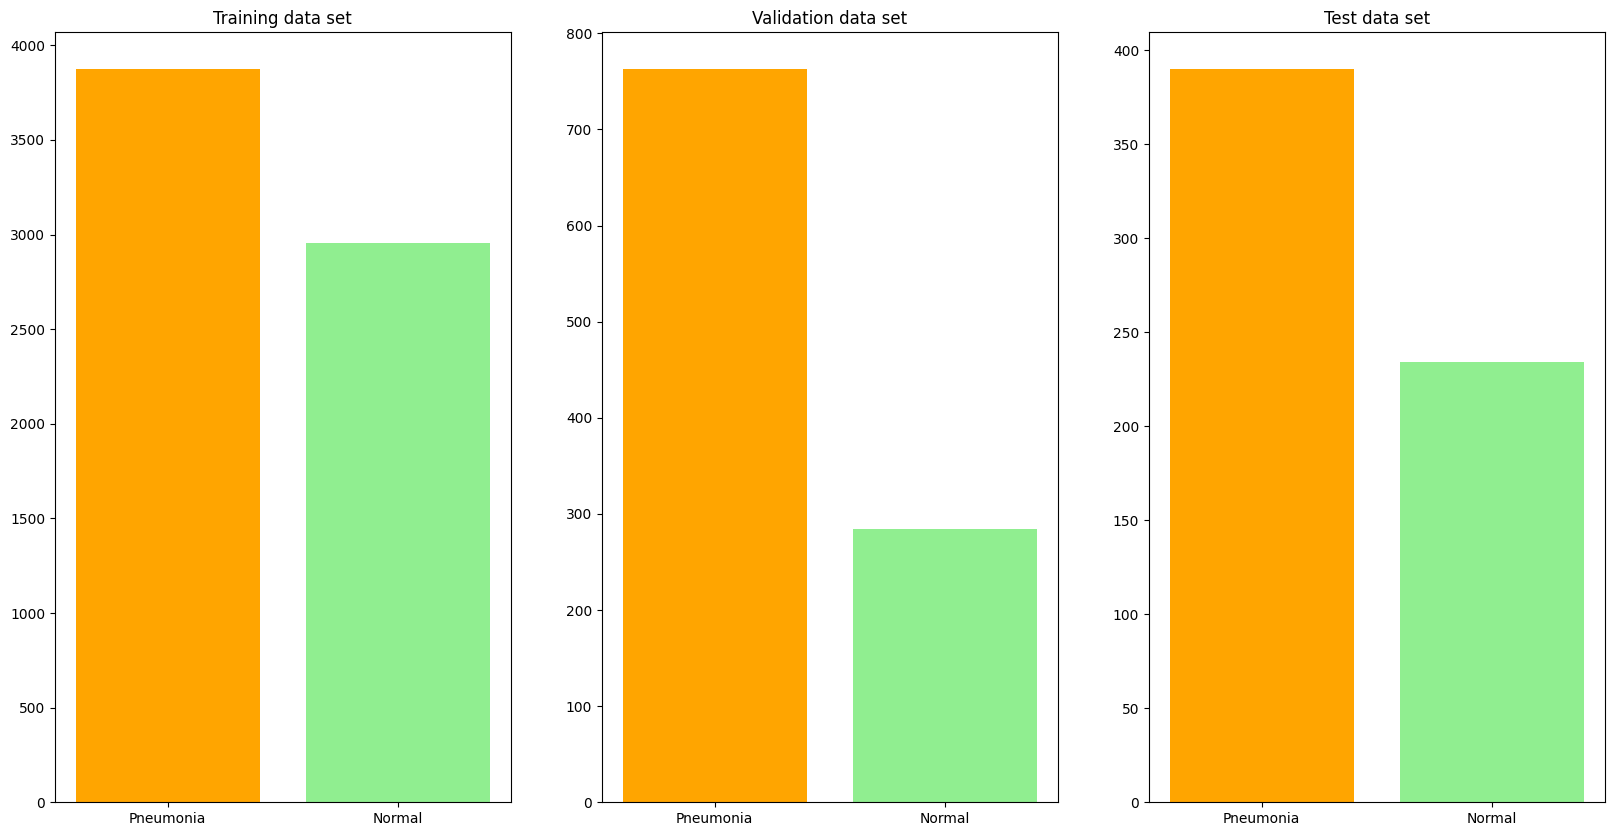

In [15]:
val_normal_count = 0
val_pneumonia_count = 0

for file in val_files:
    if "NORMAL" in file: 
        val_normal_count +=1
    else:
        val_pneumonia_count +=1

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.bar(x=["Pneumonia", "Normal"], 
        height=(len (os.listdir (train_folder + "/PNEUMONIA")) , 
                    len (os.listdir (train_folder + "/NORMAL"))
                   ) , 
        color=["orange", "lightgreen"])
plt.title("Training data set")

plt.subplot(1, 3, 2)
plt.bar(x=["Pneumonia", "Normal"], 
        height=[val_pneumonia_count, val_normal_count], 
        color=["orange", "lightgreen"])
plt.title("Validation data set")

plt.subplot (1 , 3 , 3)
plt.bar (x = ["Pneumonia","Normal"] ,
         height = (len (os.listdir (test_folder + "/PNEUMONIA")) , 
                    len (os.listdir (test_folder + "/NORMAL"))
                   ) , 
         color = ["orange", "lightgreen"])
plt.title ("Test data set")

plt.show()

#### 샘플이미지 시각화

In [16]:
# 이미지 시각화를 위해, 노멀 이미지와 폐렴이미지 리스트 만들기 
normal_list = []
pneumonia_list = []

for i in ["train", "test", "val"]:
    path = os.path.join(img_dir, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    normal_list.extend(normal)
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    pneumonia_list.extend(pneumonia)
    
print("The number of the normal lung dataset is {}".format(len(normal_list)))
print("The number of the pneumonia dataset is {}".format(len(pneumonia_list)))
    

The number of the normal lung dataset is 1583
The number of the pneumonia dataset is 4273


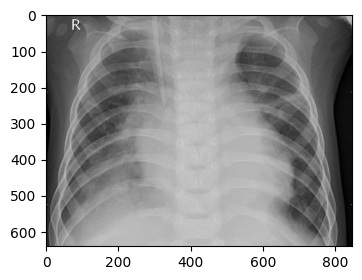

In [17]:
# 폐렴 샘플이미지 시각화
fig = plt.figure(figsize = (4,3))
plt.imshow(load_img(random.choice(pneumonia_list)))
plt.show()

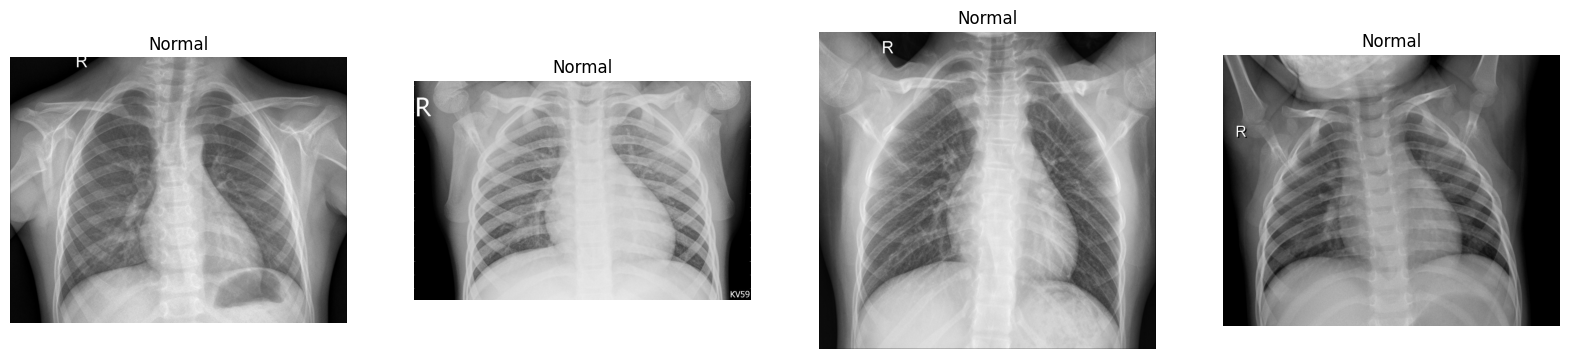

In [18]:
# 여러장의 건강한 폐 샘플이미지 시각화
fig = plt.figure(figsize = (20, 15))
columns, rows = 4, 1
for i in range(1,5):
    img = cv2.imread(random.choice(normal_list))
    fig.add_subplot(rows, columns, i)
    plt.title('Normal')
    plt.axis('off')
    plt.imshow(img)
   

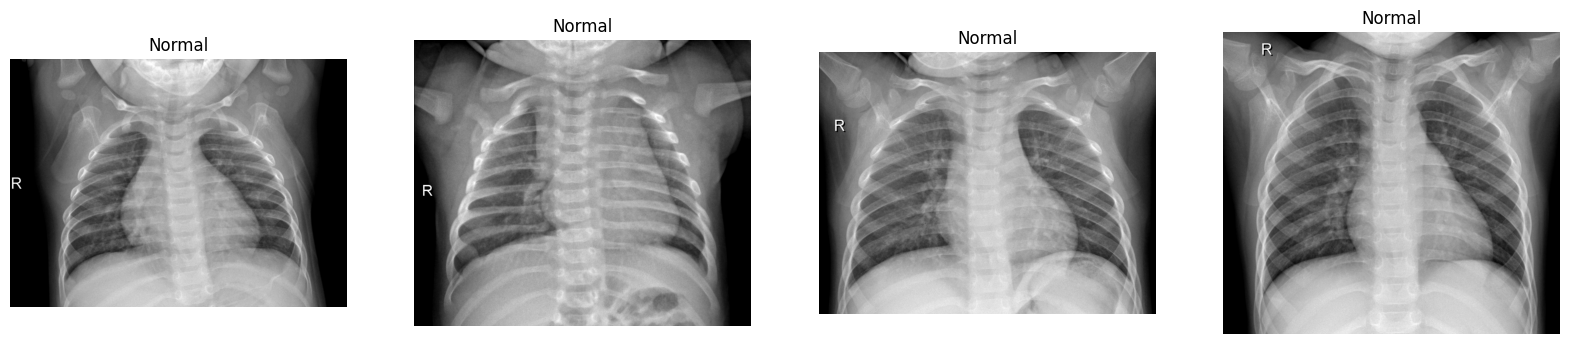

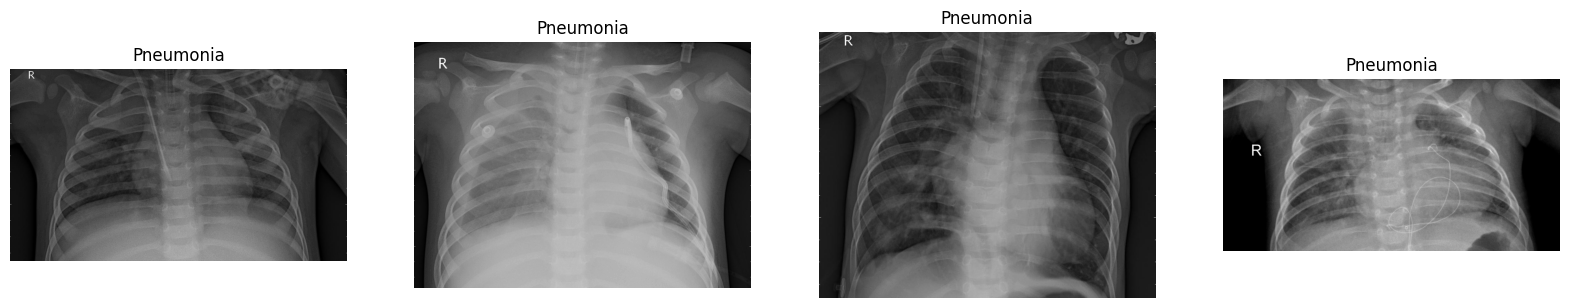

In [19]:
# 여러장의 건강한 폐 샘플이미지와 폐렴 샘플 이미지를 시각화
num_samples = 4
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(normal_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Normal')
    axes[i].axis('off')

fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(pneumonia_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Pneumonia')
    axes[i].axis('off')

###  배치 데이터세트 생성 Batch Dataset Generation

 DataGenerator는 일반적으로 전체 데이터 세트를 메모리에 맞출 수 없는 경우 Keras 모델을 학습하기 위한 데이터 일괄 처리를 생성하는 데 사용됩니다. 이미지 데이터의 양이 많으므로, DataGenerator를 사용하겠습니다. 

 일반적으로 train_generator에는 augmentation을 하고 val_generator하는 등 데이터 augmentation을 진행하지만, xray 이미지가 항상 특정한 포지션에서 사진이 찍힌다는 점을 생각해서, augmentation 부분을 코드에서 삭제하였습니다. 

In [33]:
class DataGenerator(Sequence):
    def __init__(self, file_list, batch_size=32, shuffle=True):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if self.shuffle: # 에포크가 끝날때마다 데이터를 섞어줌으로써, 모델이 같은 데이터를 학습하는 것을 방지합니다. 
            np.random.shuffle(self.file_list)
        
    def __len__(self): # 각 에포크의 배치사이즈를 리턴
        return int(np.ceil( len(self.file_list) / float(self.batch_size) ) )

    def __getitem__(self, idx): # file_list 부분은 img_path 등으로 대체될 수 있습니다. 
        batch_files = self.file_list[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        
        for file in batch_files:
            img = load_img(file, target_size=(512, 512)) # 이미지 로드
            img = img_to_array(img) / 255.0 # numpy 배열로 변환 및 normalize
            
            batch_images.append(img)
            
            if "PNEUMONIA" in file:
                label = 1
            else:
                label = 0
            batch_labels.append(label)
    
        return np.array(batch_images), np.array(batch_labels)

In [34]:
train_gen = DataGenerator(file_list=train_files, batch_size=32, shuffle=True)
val_gen = DataGenerator(file_list=val_files, batch_size=16, shuffle=True)
test_gen = DataGenerator(file_list=test_list, batch_size=16, shuffle=True)

In [28]:
def plot_images(images):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,5))
    axes = axes.ravel()
    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)


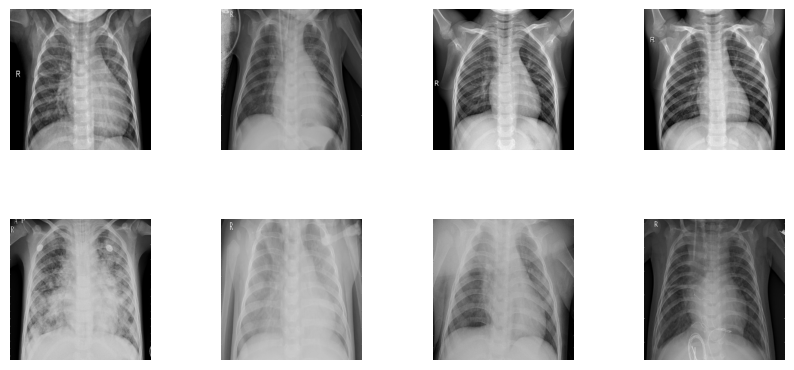

In [35]:
# 8개의 학습train 배치 이미지를 시각화 
x, y = train_gen.__getitem__(0)
plot_images(x[:8])

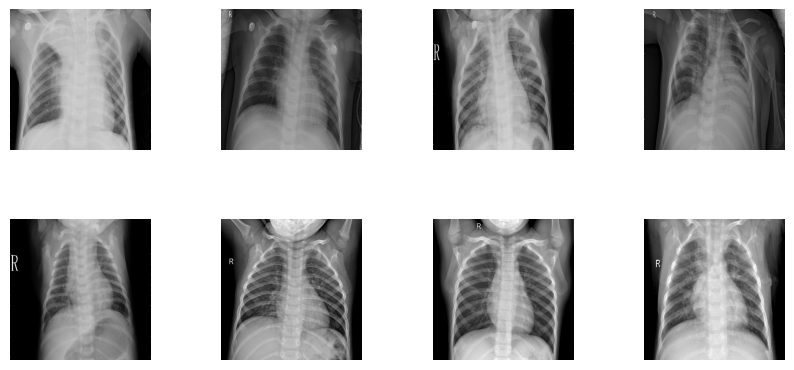

In [36]:
# 8개의 벨리데이션 배치 이미지를 시각화 
x_val, y_val = val_gen.__getitem__(0)
plot_images(x_val[:8])

### 모델 빌드 Build a model 

모델 빌드 전 고려할 사항
- 데이터가 한정적일때 딥러닝 모델 아키텍쳐를 어떻게 할 것인가 -> 심플하게 simple 
- Pretrain-model을 가져와서 transfer learning을 할때 전체를 가져올것인가 부분적으로 가져올것인가 -> 부분적으로 partially 
    - pre-trained 모델이 대규모 데이터셋에서 학습된 가중치를 사용하므로, 초기화된 가중치보다 더 좋은 초기값을 가지고 있기 때문에, Pretrain모델의 일부 레이어들의 가중치를 fine-tuning 미세조정합니다 
    - 일반적인 pre-trained모델을 살펴보면 (CNN을 예시로), 모델의 상위 레이어들은 이미지의 high-level feature(e.g. contour of object, feature)를 캡쳐하고 하위 레이어들은 low-level feature(e.g. line선 가장자리edge등의 texture feature)을 학습했습니다.
    - 때문에, 하위 레이어들에 대해서는 가중치를 동결freeze하고, 상위 레이어들을 task-specific한 feature 특징들을 학습하도록 미세조정 fine-tuning 하는것이 좋습니다. (참고로, 상위 레이어들의 high-level feature가 이미지 분류 및 객체 감지 task에서 중요합니다) 
    <br>
    - task 목표가 폐렴을 감지하는 것으로, 상위 레이어들 미세 조정 fine tuning 하여 램던하게 초기화된 가중치보다 좋은 결과를 
    - 일반적으로 fine-tuning시 Pre-trained 된 모델들의 레이어 가중치를 미세 조정하면, 랜덤하게 초기화된 가중치보다 훨씬 좋은 결과를 얻을 수 있습니다.

#### 전이모델 Pretrained VGG16

In [ ]:
# ImageNet으로 pre-trained된 VGG16 모델 불러오기
pretrained_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 미세 조정을 위해 전이모델 레이어 고정 froze
for layer in pretrained_vgg16.layers:
    layer.trainable = False


# 맞는 레이어를 froze했는지 한번 더 확인
for i, layer in enumerate(pretrained_vgg16.layers):
    print(i, layer.name, layer.trainable)

pretrained_vgg16.summary()   

In [ ]:
top_model = pretrained_vgg16.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model) # overfitting을 줄이기 위한 드롭아웃 레이어
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)

vgg_model2 = Model(inputs=pretrained_vgg16.input, outputs = prediction)
vgg_model2.summary()

#### 콜백 설정
Pedro Marcelino가 설명한 바에 따르면, 높은 학습률 high learning rate는 이전의 지식을 잃을 위험을 증가시키기 때문에, 낮은 학습률을 설정하는 것이 좋다고 합니다. <br>
모델의 개선이 없다면, learning rate를 조절해 모델의 개선을 유도하는 콜백 함수인 ReduceLROnPlateau을 사용하면 모델을 미세조정하는데 유용함으로 함수를 사용했습니다. 

- early stopping 을 통해 지표가 개선 안되는 학습과정에서 불필요한 연산 시간을 절약할 수 있으며, 최적의 모델을 얻을 수 있습니다.
- early stopping의 지표로 벨리데이션 정확도를 지정하고 ``monitor=validation_loss``, mode는 최대로 두었습니다. ``mode=max``. IㅜceptionV3에서는 ```mode=auto```로 변경하였습니다. 
- patience를 5로하여 5epoch동안 지표가 개선 안되면 학습을 중단하도록 설정하였습니다

In [30]:
# early stopping의 지표로 벨리데이션 정확도를 선택 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
                           mode='min', 
                           restore_best_weights=True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, # 새로운 learning rate는 기존 learning rate * factor
                                   patience=10, # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
                                   verbose=1, # 1일경우 EarlyStopping이 적용될때 적용되었다고 나타냅니다. 
                                   mode='auto', # monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자
                                   epsilon=0.0001, # 개선된 것으로 간주하기 위한 최소한의 변화량
                                   min_lr=5e-5)

# 옵티마이저로 Adam을 선택
opt1 = Adam(lr=1e-5) # 00001
opt2 = Adam(lr=5e-5) # 00005

In [ ]:
# 모델 컴파일
vgg_model2.compile(loss='binary_crossentropy',
                   optimizer=opt2,
                   metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_callback = ModelCheckpoint(
    # 학습중 벨리데이션 정확도가 증가시, 파일경로에 모델의 가중치를 저장
    filepath="saved_model/xray_vgg16_model2.h5" ,
    # 모니터 부분에 지표로 벨리데이션 정확도를 명시, 모드 부분은 지표를 최대 지정하여 최고의 정확도인지를 모니터링 
    monitor='val_accuracy',
    mode='max',
    # 최고버전의 모델을 보장
    save_best_only=True
)

# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
vgg_history = vgg_model2.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])
# 걸린 시간 계산
elapsed_time = time.time() - start_time
# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

In [45]:
#vgg_model2.save('saved_model/xray_vgg16_model2.h5')
vgg_model1 = load_model('saved_model/xray_vgg16_model1.h5')
vgg_model2 = load_model('saved_model/xray_vgg16_model2.h5')

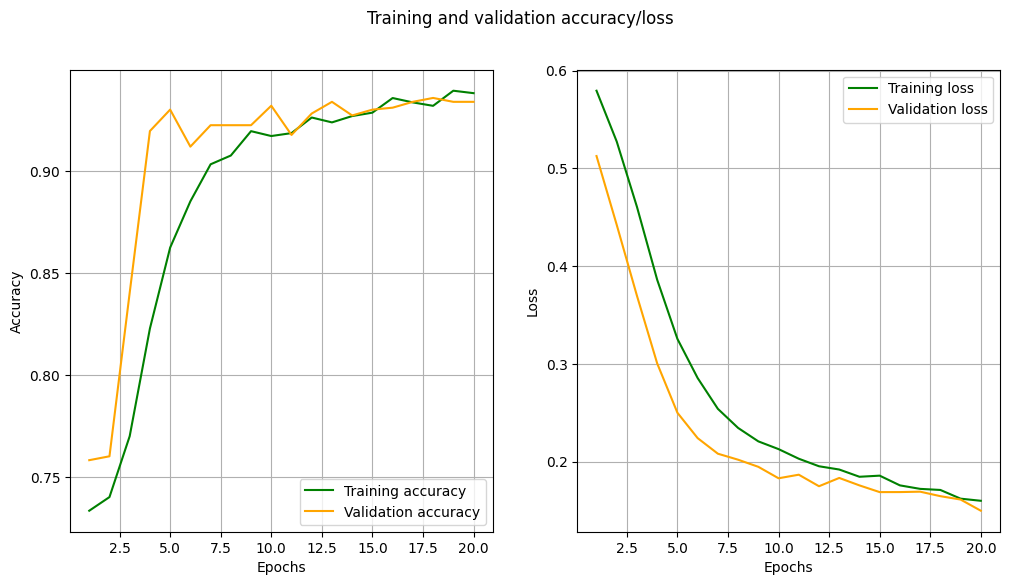

In [50]:
vgg_train_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']
vgg_train_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']
epochs = range(1, len(vgg_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, vgg_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, vgg_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, vgg_train_loss, color='green', label='Training loss')
ax2.plot(epochs, vgg_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Training and validation accuracy/loss')
plt.show()

In [51]:
# VGG16 모델 평가
vgg_test_loss, vgg_test_accu = vgg_model2.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(vgg_test_loss, vgg_test_acccuracy))

Test loss is: 0.5830598473548889, Test Accuracy is: 0.7724359035491943


#### 전이모델 Pretrained Resnet50
- 베이스 모델로 pretrained resnet50을 넣어주고, input 사이즈를 224,224,3로 지정하였습니다. 
- 때문에 data augmentation에서 Resize부분을 A.Resize(256,256)로 바꿔주고, 이미지를 랜덤으로 크롭하는 부분을 A.RandomCrop(224, 224)로 바꾸어 준 뒤에 모델 학습을 진행했습니다

In [ ]:
# ImageNet으로 pre-trained된 ResNet50 모델 로드
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# 모델 구조 출력
resnet_base.summary()

# 기본 모델 동결 
resnet_base.trainable = False

In [ ]:
top_model = resnet_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)
# 새로운 모델 생성
resnet_model1 = Model(inputs=resnet_base.input, outputs=prediction)

# 새로운 모델 구조 출력
resnet_model1.summary()

In [65]:
# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
resnet_model1.compile(optimizer=opt1, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_res50_model1.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)


# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
res_history = resnet_model1.fit(train_gen,
                                epochs=20,
                                validation_data=val_gen,
                                callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 347s 3s/step - loss: 0.8301 - accuracy: 0.6860 - val_loss: 0.4361 - val_accuracy: 0.7593 - lr: 1.0000e-05
Epoch 2/20
131/131 [==============================] - 293s 2s/step - loss: 0.6612 - accuracy: 0.6898 - val_loss: 0.3751 - val_accuracy: 0.7966 - lr: 1.0000e-05
Epoch 3/20
131/131 [==============================] - 293s 2s/step - loss: 0.5703 - accuracy: 0.7240 - val_loss: 0.3479 - val_accuracy: 0.8376 - lr: 1.0000e-05
Epoch 4/20
131/131 [==============================] - 293s 2s/step - loss: 0.5027 - accuracy: 0.7529 - val_loss: 0.3356 - val_accuracy: 0.8500 - lr: 1.0000e-05
Epoch 5/20
131/131 [==============================] - 293s 2s/step - loss: 0.4602 - accuracy: 0.7783 - val_loss: 0.3203 - val_accuracy: 0.8520 - lr: 1.0000e-05
Epoch 6/20
131/131 [==============================] - 293s 2s/step - loss: 0.4280 - accuracy: 0.7967 - val_loss: 0.3163 - val_accuracy: 0.8558 - lr: 1.0000e-05
Epoch 7/20
131/131 [====================

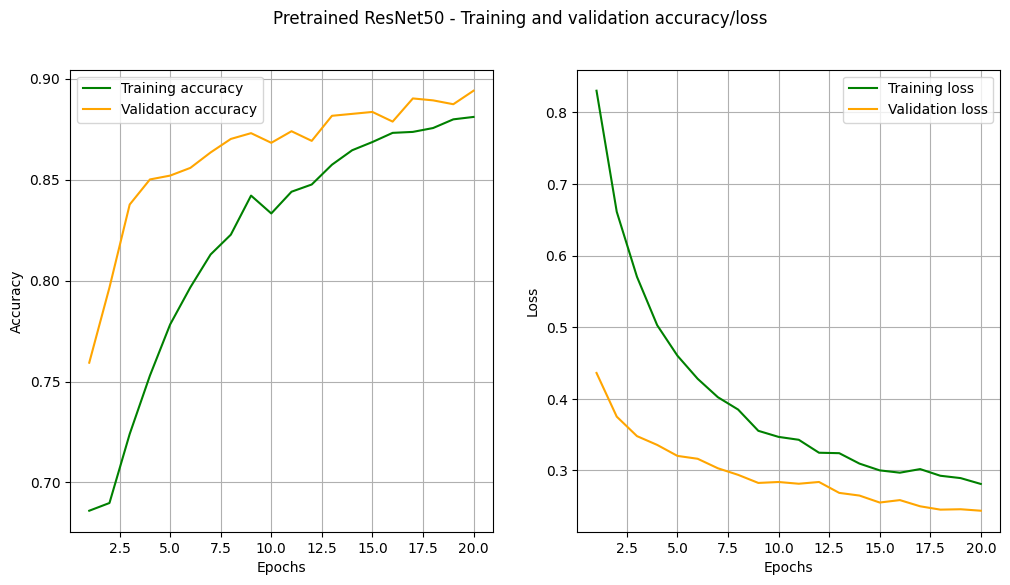

In [68]:
res_train_loss = res_history.history['loss']
res_val_loss = res_history.history['val_loss']
res_train_acc = res_history.history['accuracy']
res_val_acc = res_history.history['val_accuracy']
epochs = range(1, len(res_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, res_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, res_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, res_train_loss, color='green', label='Training loss')
ax2.plot(epochs, res_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained ResNet50 - Training and validation accuracy/loss')
plt.show()

In [69]:
# resnet50 모델 평가1
res_test_loss, res_test_accu = resnet_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(res_test_loss, res_test_accu))

resnet_model1.save(checkpoint_filepath)

Test loss is: 0.4932659864425659, Test Accuracy is: 0.7612179517745972


In [37]:
resnet_model1 = load_model('saved_model/xray_resnet_model1.h5')

#### 전이모델 Pretrained InceptionV3

In [ ]:
# ImageNet으로 pre-trained된 InceptionV3 모델 로드
inc_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# 모델 구조 출력
inc_base.summary()

# 기본 모델 레이어 동결 
for layer in inc_base.layers:   
    layer.trainable = False

# 레이어 추가 
top_model = inc_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)
# 새로운 모델 생성
inc_model1 = Model(inputs=inc_base.input, outputs=prediction)

# 새로운 모델 구조 출력
inc_model1 .summary()

In [28]:
# early stopping의 지표로 벨리데이션 정확도를 선택 
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           mode='auto', # InceptionV3에서는 min에서 auto로 변경
                           restore_best_weights=True)

# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
inc_model1.compile(optimizer=opt1, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_inception_model1.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)


# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
inc_history = inc_model1.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 197s 1s/step - loss: 0.7204 - accuracy: 0.6409 - val_loss: 0.5426 - val_accuracy: 0.7670 - lr: 1.0000e-05
Epoch 2/20
131/131 [==============================] - 125s 952ms/step - loss: 0.5749 - accuracy: 0.7231 - val_loss: 0.4614 - val_accuracy: 0.8309 - lr: 1.0000e-05
Epoch 3/20
131/131 [==============================] - 124s 943ms/step - loss: 0.5416 - accuracy: 0.7455 - val_loss: 0.3867 - val_accuracy: 0.8797 - lr: 1.0000e-05
Epoch 4/20
131/131 [==============================] - 124s 944ms/step - loss: 0.4784 - accuracy: 0.7718 - val_loss: 0.3234 - val_accuracy: 0.8997 - lr: 1.0000e-05
Epoch 5/20
131/131 [==============================] - 124s 942ms/step - loss: 0.4498 - accuracy: 0.7959 - val_loss: 0.2993 - val_accuracy: 0.8968 - lr: 1.0000e-05
Epoch 6/20
131/131 [==============================] - 124s 945ms/step - loss: 0.4163 - accuracy: 0.8155 - val_loss: 0.2876 - val_accuracy: 0.9016 - lr: 1.0000e-05
Epoch 7/20
131/131 [=====

In [29]:
# InceptionV3 모델 평가1
inc_test_loss, inc_test_accu = inc_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(inc_test_loss, inc_test_accu))

inc_model1.save(checkpoint_filepath)

Test loss is: 0.3707568645477295, Test Accuracy is: 0.8365384340286255


In [49]:
inc_model1 = load_model('saved_model/xray_inception_model1.h5')

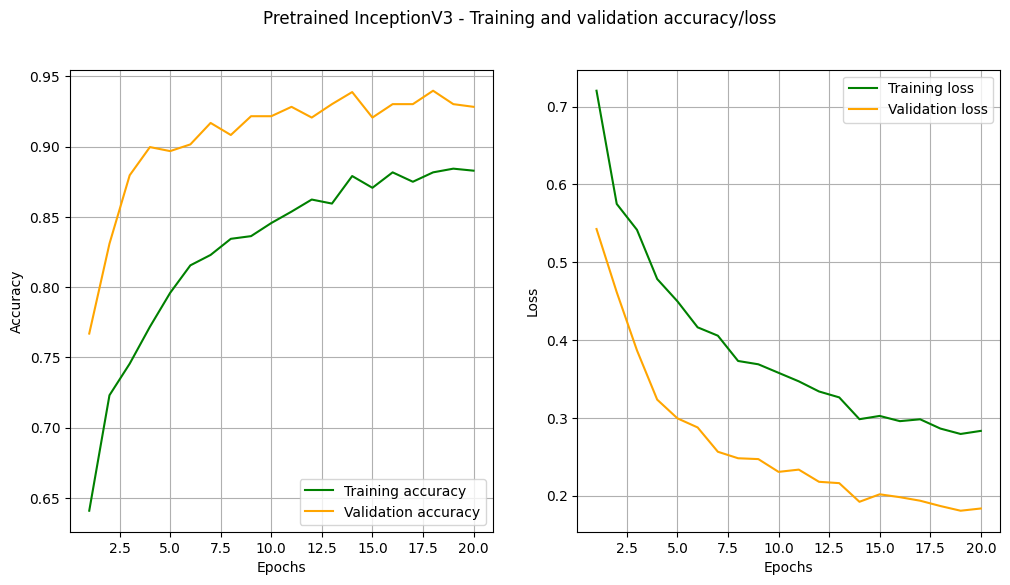

In [30]:
inc_train_loss = inc_history.history['loss']
inc_val_loss = inc_history.history['val_loss']
inc_train_acc = inc_history.history['accuracy']
inc_val_acc = inc_history.history['val_accuracy']
epochs = range(1, len(inc_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, inc_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, inc_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, inc_train_loss, color='green', label='Training loss')
ax2.plot(epochs, inc_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained InceptionV3 - Training and validation accuracy/loss')
plt.show()

#### 전이모델 Pretrained Xception

In [ ]:
# ImageNet으로 pre-trained된 Xception 모델 로드
xce_base = Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# 모델 구조 출력
xce_base.summary()

# 기본 모델 레이어 동결 
for layer in xce_base.layers:   
    layer.trainable = False

# 레이어 추가 
top_model = xce_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)
# 새로운 모델 생성
xce_model1 = Model(inputs=xce_base.input, outputs=prediction)

# 새로운 모델 구조 출력
xce_model1 .summary()

In [32]:
# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
xce_model1.compile(optimizer=opt1, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_xception_model1.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
xce_history = xce_model1.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 293s 2s/step - loss: 0.6116 - accuracy: 0.6915 - val_loss: 0.5829 - val_accuracy: 0.9035 - lr: 1.0000e-05
Epoch 2/20
131/131 [==============================] - 268s 2s/step - loss: 0.4293 - accuracy: 0.8103 - val_loss: 0.4629 - val_accuracy: 0.9207 - lr: 1.0000e-05
Epoch 3/20
131/131 [==============================] - 268s 2s/step - loss: 0.3721 - accuracy: 0.8432 - val_loss: 0.3217 - val_accuracy: 0.9427 - lr: 1.0000e-05
Epoch 4/20
131/131 [==============================] - 268s 2s/step - loss: 0.3507 - accuracy: 0.8499 - val_loss: 0.2414 - val_accuracy: 0.9417 - lr: 1.0000e-05
Epoch 5/20
131/131 [==============================] - 268s 2s/step - loss: 0.3230 - accuracy: 0.8626 - val_loss: 0.2154 - val_accuracy: 0.9284 - lr: 1.0000e-05
Epoch 6/20
131/131 [==============================] - 268s 2s/step - loss: 0.3098 - accuracy: 0.8757 - val_loss: 0.1921 - val_accuracy: 0.9379 - lr: 1.0000e-05
Epoch 7/20
131/131 [====================

In [33]:
# Xception 모델 평가1
xce_test_loss, xce_test_accu = xce_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(xce_test_loss, xce_test_accu))

xce_model1.save(checkpoint_filepath)

Test loss is: 0.3583202064037323, Test Accuracy is: 0.8397436141967773


In [53]:
xce_model1 = load_model('saved_model/xray_xception_model1.h5')

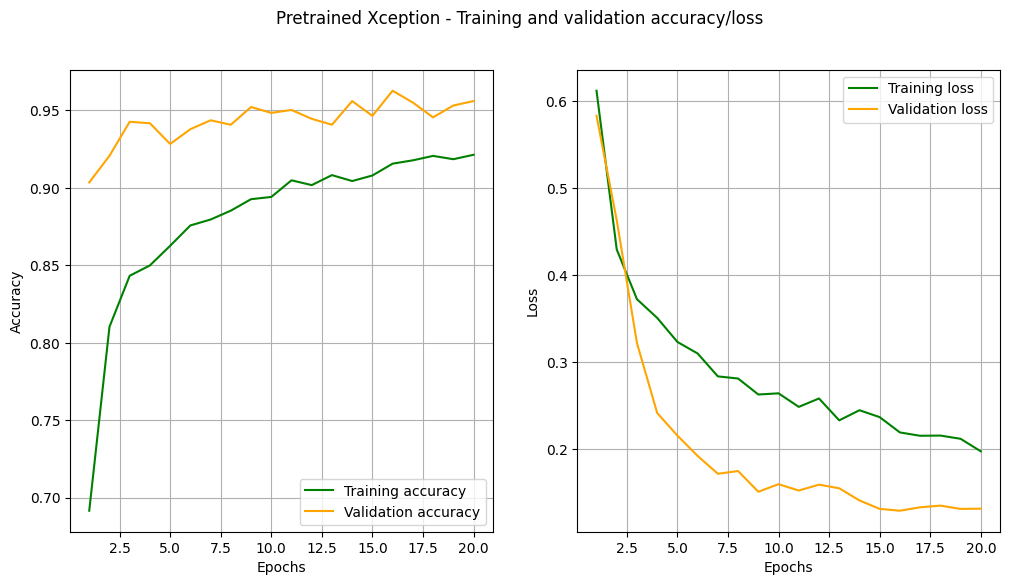

In [34]:
xce_train_loss = xce_history.history['loss']
xce_val_loss = xce_history.history['val_loss']
xce_train_acc = xce_history.history['accuracy']
xce_val_acc = xce_history.history['val_accuracy']
epochs = range(1, len(xce_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, xce_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, xce_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, xce_train_loss, color='green', label='Training loss')
ax2.plot(epochs, xce_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained Xception - Training and validation accuracy/loss')
plt.show()

#### 전이모델 Pretrained EfficientNetB0

In [39]:
# ImageNet으로 pre-trained된 EfficientNet 모델 로드
eff_base = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# 기본 모델 레이어 동결 
for layer in eff_base.layers:   
    layer.trainable = False

# 레이어 추가 
top_model = eff_base.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = BatchNormalization()(top_model) # 두번째 시도에 더해진 라인 
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model) # 두번째 시도에 더해진 라인 
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
prediction = Dense(1, activation='sigmoid')(top_model)

# 새로운 모델 생성
eff_model2 = Model(inputs=eff_base.input, outputs=prediction)

In [41]:
# 새로운 학습률 설정
weight_decay = 0.001
opt3 = Adam(lr=0.001, decay=weight_decay)

# 모델 컴파일, fine-tuning 시 optimizer, loss function, metric 등 설정
eff_model2.compile(optimizer=opt3, # 세번째 시도로 learning rate를 더 작게 설정
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_EfficinetNet_model2.h5' 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)

# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
eff_history = eff_model2.fit(train_gen,
                             epochs=20,
                             validation_data=val_gen,
                             callbacks=[early_stop, reduceLROnPlat, checkpoint_callback])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 67s 476ms/step - loss: 0.4797 - accuracy: 0.7649 - val_loss: 0.4457 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 61s 465ms/step - loss: 0.4765 - accuracy: 0.7692 - val_loss: 0.4428 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 62s 470ms/step - loss: 0.4711 - accuracy: 0.7849 - val_loss: 0.4938 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 61s 465ms/step - loss: 0.4627 - accuracy: 0.7790 - val_loss: 0.4229 - val_accuracy: 0.7689 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 62s 473ms/step - loss: 0.4525 - accuracy: 0.7912 - val_loss: 0.5069 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 6/20
131/131 [==============================] - 61s 467ms/step - loss: 0.4491 - accuracy: 0.7902 - val_loss: 0.5406 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 7/20
131/131 [==============================] 

In [39]:
# EfficientNet 모델 평가1
eff_test_loss, eff_test_accu = eff_model1.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(eff_test_loss, eff_test_accu))

eff_model1.save(checkpoint_filepath)

Test loss is: 0.6859423518180847, Test Accuracy is: 0.625


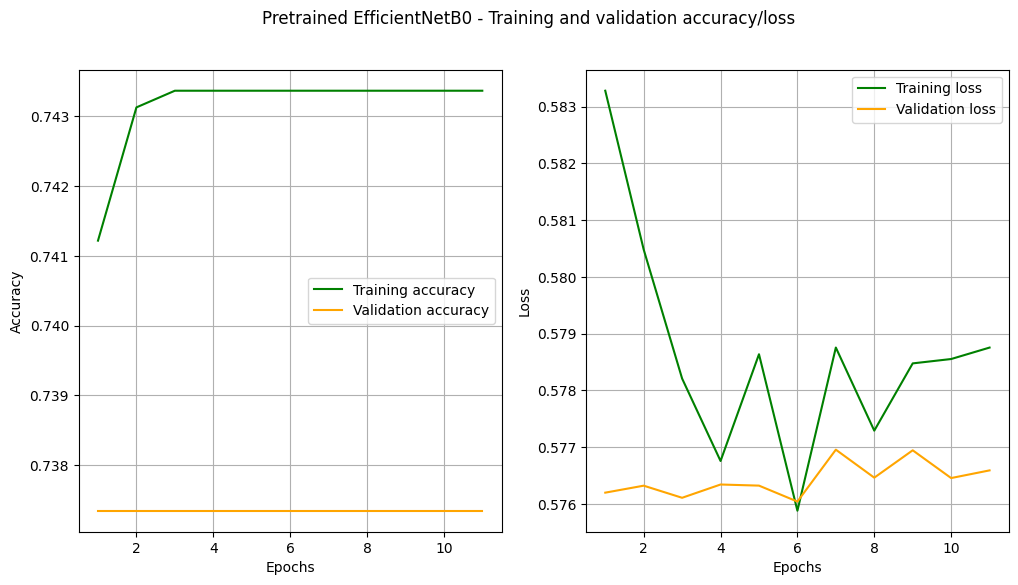

In [40]:
eff_train_loss = eff_history.history['loss']
eff_val_loss = eff_history.history['val_loss']
eff_train_acc = eff_history.history['accuracy']
eff_val_acc = eff_history.history['val_accuracy']
epochs = range(1, len(eff_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, eff_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, eff_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, eff_train_loss, color='green', label='Training loss')
ax2.plot(epochs, eff_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained EfficientNetB0 - Training and validation accuracy/loss')
plt.show()

벨리데이션 정확도 그래프의 라인이 플랫한 것은 EfficientNetB0 베이스의 모델이 더 이상 향상되지 않고 있음을 의미합니다. <br>
이유는 여러가지일 수 있는데, 오버피팅이거나, 데이터가 부족하거나, 하이퍼 파라미터 튜닝이 좋지 않거나, 모델의 capacity가 되지 않아서 일 수 있습니다. <br>
때문에 두번째 시도에 overfitting을 염두에 두고, 옵티마이저 adam의 learning rate를 0.00001에서 0.001 바꾸어 넣어주었습니다. (일반적으로 높은 학습률과 낮은 배치 사이즈가 모델이 깊고 좁은 minima에 갇히는것을 방지하기 때문입니다.)

In [42]:
# EfficientNet 모델 평가2
eff_test_loss, eff_test_accu = eff_model2.evaluate_generator(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(eff_test_loss, eff_test_accu))

eff_model2.save(checkpoint_filepath)

Test loss is: 0.6194588541984558, Test Accuracy is: 0.6330128312110901


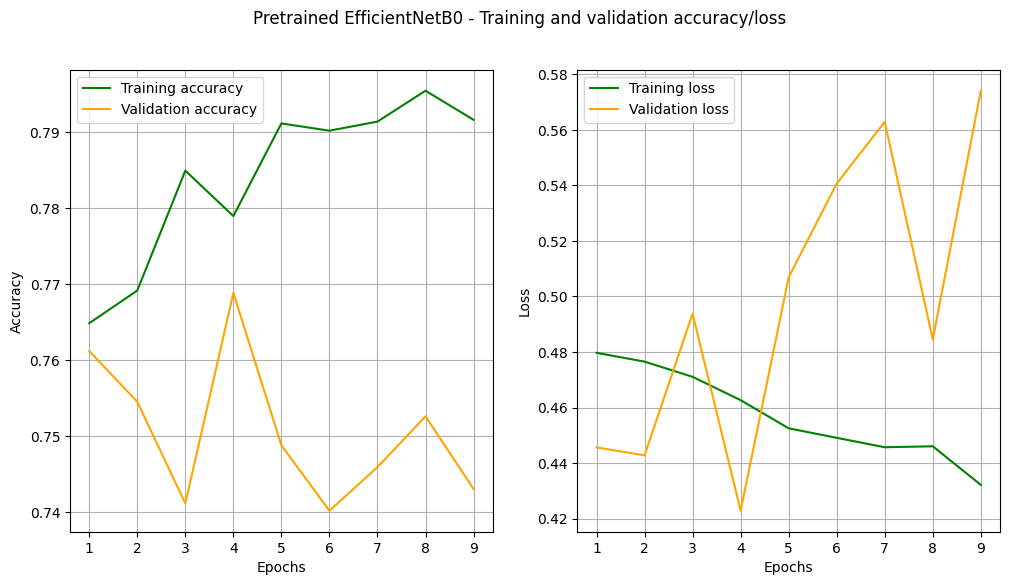

In [44]:
eff_train_loss = eff_history.history['loss']
eff_val_loss = eff_history.history['val_loss']
eff_train_acc = eff_history.history['accuracy']
eff_val_acc = eff_history.history['val_accuracy']
epochs = range(1, len(eff_train_acc) + 1)

# 두 개의 서브플롯을 가진 하나의 피규어
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 정확도를 왼쪽 서브플롯에 플롯
ax1.plot(epochs, eff_train_acc, 'green', label='Training accuracy')
ax1.plot(epochs, eff_val_acc, 'orange', label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# 손실을 오른쪽 서브플롯에 플롯
ax2.plot(epochs, eff_train_loss, color='green', label='Training loss')
ax2.plot(epochs, eff_val_loss, color='orange', label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.suptitle('Pretrained EfficientNetB0 - Training and validation accuracy/loss')
plt.show()

### 예측과 평가 Prediction and Evaluation

폐렴이라는 사람의 몸 상태를 예측하는 모델이기에, 실제 폐렴인데 폐렴이 아닌 정상이라고 판단하는 모델 보다는, 폐렴이 아닌데 폐렴이라도 예측하는 모델이 낫습니다. 
<br> 
하지만 딥러닝 모델에 예측을 의지하지 않고, 의료진에게 도움을 주는 측면이 더 크기에 일반적인 평가를 내리면 두번째 vgg16 전이 모델의 Confusion Matrix가 좋은 값을 보여주고 ROC_AUC 값이 0.803으로 가장 좋은 그래프를 보여주고 있습니다. 

#### Pretrained VGG16 model evaluation

In [39]:
# 테스트 파일들의 실제 레이블을 저장하기 위해 빈 리스트 생성합니다. 
test_labels = []

# 각 파일 경로마다 루프
for file_path in test_list:
    
    if "PNEUMONIA" in file_path:
        test_labels.append(1)
    else: 
        test_labels.append(0)
        
    # 파일경로에서 상위 디렉토리의 이름을 가져옵니다. "NORMAL" 이거나 "PNEUMONIA" 
    # label = os.path.basename(os.path.dirname(file_path))
    # 추출한 레이블을 실제 레이블 리스트에 추가합니다. 
    # test_labels.append(label)

# 처음 5개의 실제 레이블을 출력해서 테스트
print(test_labels[:5])
print(test_list[:5])

[1, 1, 0, 0, 1]
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\PNEUMONIA\\person139_bacteria_664.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\PNEUMONIA\\person111_bacteria_535.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\NORMAL\\IM-0016-0001.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\NORMAL\\IM-0091-0001.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest-xray-pneumonia/chest_xray/test\\PNEUMONIA\\person23_virus_56.jpeg']


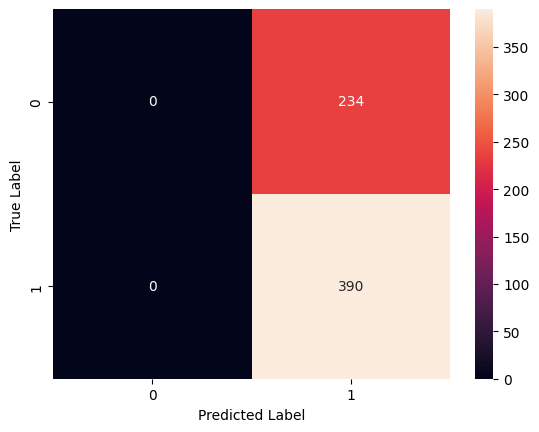

In [46]:
y_pred1 = np.where(vgg_model1.predict(test_gen) > 0.5, 1, 0)

vgg16_model1_cm = confusion_matrix(test_labels, y_pred1)
sns.heatmap(vgg16_model1_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()

In [56]:
print(len(y_pred1))
print(len(test_labels))

624
624


In [68]:
# vgg16 model1 classification report
print(classification_report(test_labels, y_pred1))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55       234
           1       0.73      0.97      0.83       390

    accuracy                           0.75       624
   macro avg       0.80      0.68      0.69       624
weighted avg       0.78      0.75      0.72       624



ROC_AUC:  0.5


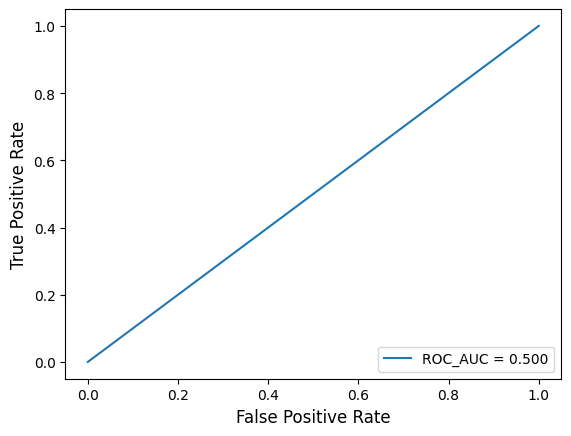

In [47]:
roc_auc = roc_auc_score(test_labels, y_pred1)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred1)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

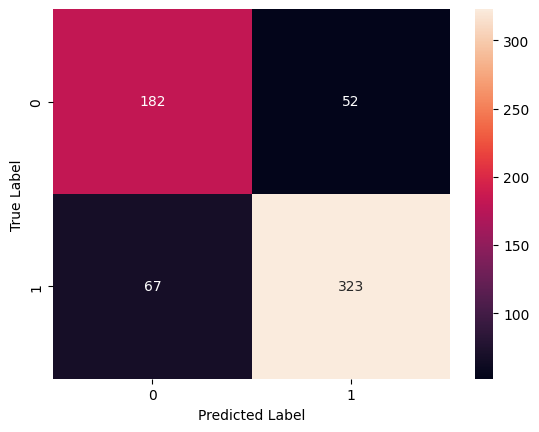

In [69]:
y_pred2 = np.where(vgg_model2.predict(test_gen) > 0.5, 1, 0)

vgg_model2_cm = confusion_matrix(test_labels, y_pred2)
sns.heatmap(vgg_model2_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()

In [71]:
# vgg16 model2 classification report
print(classification_report(test_labels, y_pred2))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       234
           1       0.86      0.83      0.84       390

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.80       624
weighted avg       0.81      0.81      0.81       624



ROC_AUC:  0.8029914529914531


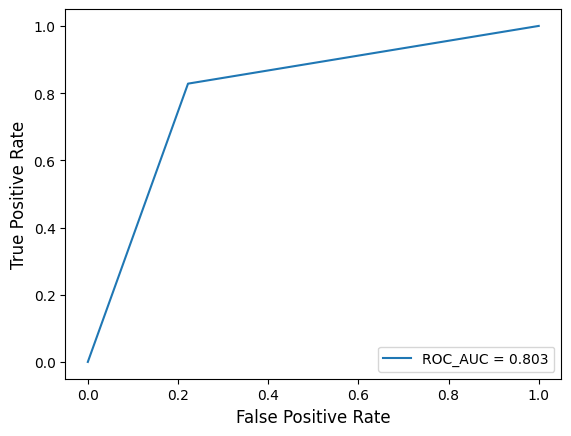

In [72]:
roc_auc = roc_auc_score(test_labels, y_pred2)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred2)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

#### Pretrained Resnet50 model evaluation

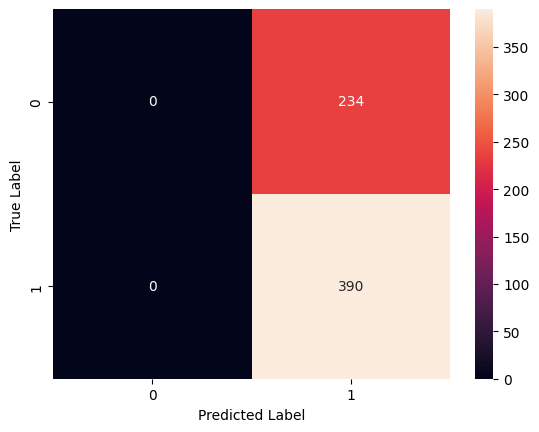

In [40]:
y_pred3 = np.where(resnet_model1.predict(test_gen) > 0.5, 1, 0)

res_model1_cm = confusion_matrix(test_labels, y_pred3)
sns.heatmap(res_model1_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()

In [41]:
# resnet50 model1 classification report
print(classification_report(test_labels, y_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



ROC_AUC:  0.5


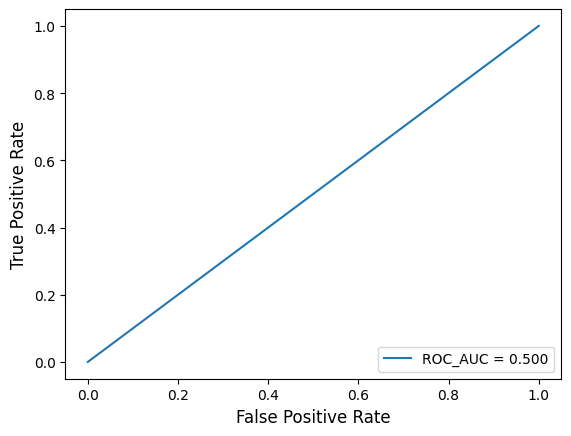

In [42]:
roc_auc = roc_auc_score(test_labels, y_pred3)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred3)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

#### Pretrained InceptionV3 model evaluation

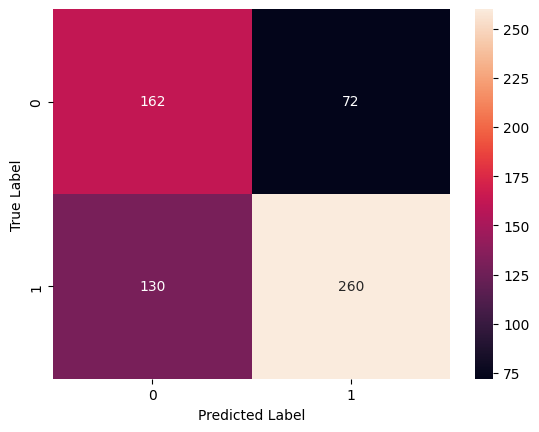

In [50]:
y_pred4 = np.where(inc_model1.predict(test_gen) > 0.5, 1, 0)

inc_model1_cm = confusion_matrix(test_labels, y_pred4)
sns.heatmap(inc_model1_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()


In [51]:
# InceptionV3 model1 classification report
print(classification_report(test_labels, y_pred4))

              precision    recall  f1-score   support

           0       0.55      0.69      0.62       234
           1       0.78      0.67      0.72       390

    accuracy                           0.68       624
   macro avg       0.67      0.68      0.67       624
weighted avg       0.70      0.68      0.68       624



ROC_AUC:  0.6794871794871794


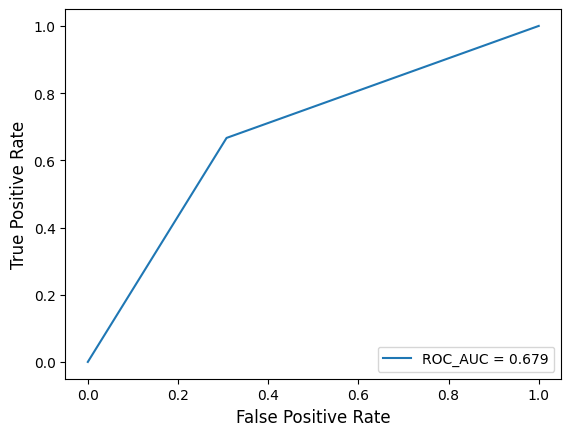

In [52]:
roc_auc = roc_auc_score(test_labels, y_pred4)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred4)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

#### Pretrained Xception model evaluation

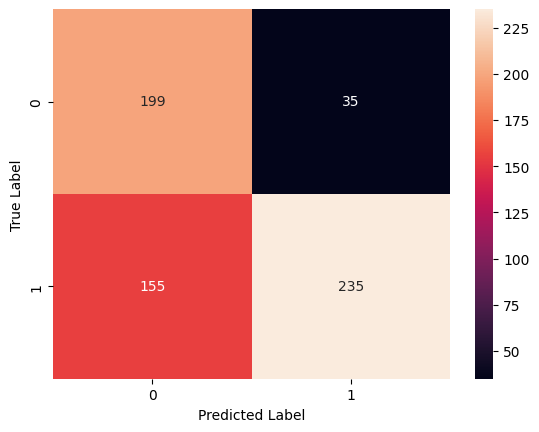

In [57]:
y_pred5 = np.where(xce_model1.predict(test_gen) > 0.5, 1, 0)

xce_model1_cm = confusion_matrix(test_labels, y_pred5)
sns.heatmap(xce_model1_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()


In [58]:
# Xception model1 classification report
print(classification_report(test_labels, y_pred5))

              precision    recall  f1-score   support

           0       0.56      0.85      0.68       234
           1       0.87      0.60      0.71       390

    accuracy                           0.70       624
   macro avg       0.72      0.73      0.69       624
weighted avg       0.75      0.70      0.70       624



ROC_AUC:  0.7264957264957265


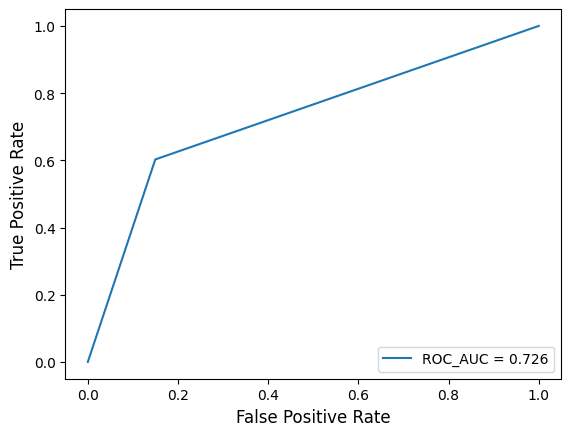

In [59]:
roc_auc = roc_auc_score(test_labels, y_pred5)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred5)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

#### Pretrained EfficientNetB0 model evaluation

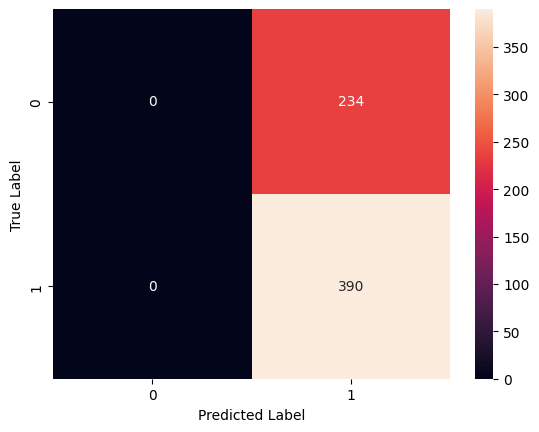

In [60]:
y_pred6 = np.where(eff_model1.predict(test_gen) > 0.5, 1, 0)

eff_model1_cm = confusion_matrix(test_labels, y_pred6)
sns.heatmap(eff_model1_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()

In [65]:
# EfficientNetB0 model1 classification report
print(classification_report(test_labels, y_pred6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



ROC_AUC:  0.5


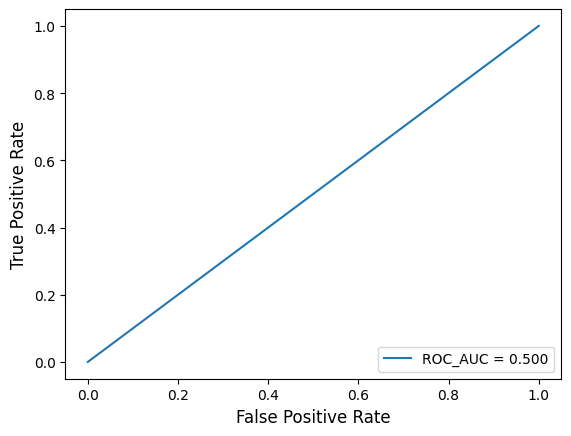

In [62]:
roc_auc = roc_auc_score(test_labels, y_pred6)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred6)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

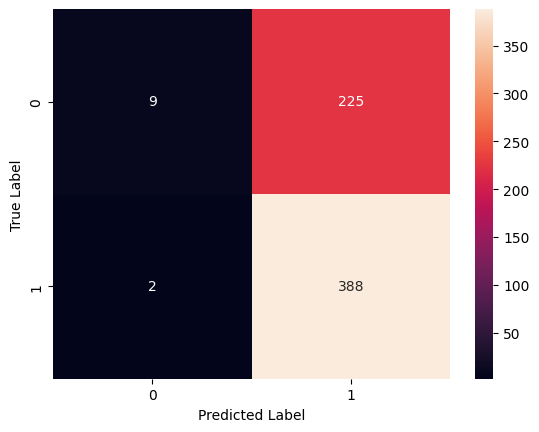

In [63]:
y_pred7 = np.where(eff_model2.predict(test_gen) > 0.5, 1, 0)

eff_model2_cm = confusion_matrix(test_labels, y_pred7)
sns.heatmap(eff_model2_cm, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 10)
plt.ylabel("True Label", fontsize= 10)

plt.show()

In [66]:
# EfficientNetB0 model2 classification report
print(classification_report(test_labels, y_pred7))

              precision    recall  f1-score   support

           0       0.82      0.04      0.07       234
           1       0.63      0.99      0.77       390

    accuracy                           0.64       624
   macro avg       0.73      0.52      0.42       624
weighted avg       0.70      0.64      0.51       624



ROC_AUC:  0.5166666666666666


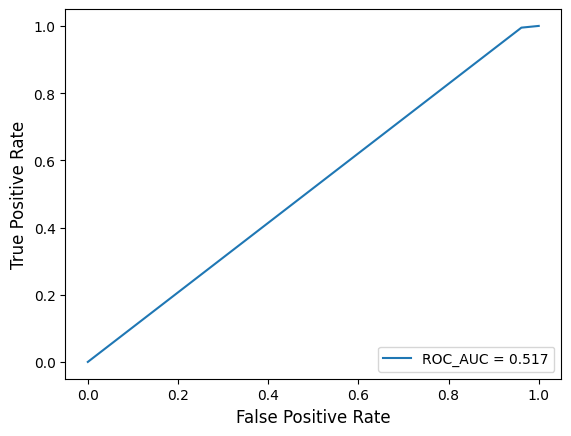

In [67]:
roc_auc = roc_auc_score(test_labels, y_pred7)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = roc_curve(test_labels, y_pred7)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

### 레퍼런스 
1. https://www.kaggle.com/code/mohitkeshwanii/pneumonia-detection-ensemble-vgg16-mobilenetv2#Helper-Functions
2. https://towardsdatascience.com/cifar-100-transfer-learning-using-efficientnet-ed3ed7b89af2
3. https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
4. https://keep-steady.tistory.com/35
5. https://webnautes.tistory.com/1578